# Sample client code to communicate with TF Serving on the GPU worker
## Time-series prediction using a seq2seq model

### Version: v1.2
#### model_name=seq2seq_timeseries. The input and output tensors in this version are multidimensional.

### Licenses/Credits
* Copyright (c) 2019, PatternedScience Inc. This code was originally run on the [UniAnalytica platform](https://www.unianalytica.com/), is published by PatternedScience Inc. on GitHub and is licensed under the terms of Apache License 2.0; a copy of the license is available in the GitHub repository;

* The visualization code snippet are based on [the work by Guillaume Chevalier](https://github.com/guillaume-chevalier/seq2seq-signal-prediction) (MIT License).

### Run this on the command line on the GPU worker to launch TF Serving

If something else is using the GPU on the worker (e.g., the training code/notebook), it's better to shut it down first.

### Package imports, parameters, var initializations

In [5]:
import json
from urllib.request import urlopen
import time
from datetime import datetime
import pytz
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

model_server_host_address = '10.0.0.55'
rest_api_port = 8501
model_name = 'seq2seq_timeseries'
model_ver = 1

nb_predictions = 5

seq_length_in = 10
seq_length_out = 5
input_dim = 1
output_dim = 1
dataset_x = []
dataset_y = []

### Creating a dataset to send for predictions

In [6]:
for _ in range(nb_predictions):
    rand = random.random() * 2 * math.pi

    sig1 = np.sin(np.linspace(0.0 * math.pi + rand,
                              3.0 * math.pi + rand, seq_length_in + seq_length_out))
    sig2 = np.cos(np.linspace(0.0 * math.pi + rand,
                              3.0 * math.pi + rand, seq_length_in + seq_length_out))
        
    x1 = sig1[:seq_length_in]
    y1 = sig1[seq_length_in:]
    
    if input_dim == 1:
        x_=np.tile(x1[:,None], input_dim)
    
    elif input_dim == 2:
        x2 = sig2[:seq_length_in]
        x_ = np.array([x1, x2])
        x_= x_.T
    
    if output_dim == 1:
        y_=np.tile(y1[:,None], output_dim)
    
    elif output_dim == 2:
        y2 = sig2[seq_length_in:]
        y_ = np.array([y1, y2])
        y_= y_.T

    dataset_x.append(x_)
    dataset_y.append(y_)

X = np.array(dataset_x).transpose((1, 0, 2))
Y = np.array(dataset_y).transpose((1, 0, 2))

### Sending the data to the server and getting the results back in `outputs`

In [7]:
now = datetime.now(pytz.timezone('US/Eastern'))
seconds_since_epoch_start = time.mktime(now.timetuple())
now_microsecond_start = now.microsecond

def CallREST(name, url, req):
  print('Sending {} request to {} with data:\n{}'.format(name, url, req))
  resp = urlopen(url, data=json.dumps(req).encode())
  #.dumps() changes JSON to string and .encode() returns a byte object
  resp_data = resp.read()
  print('Received response:\n{}'.format(resp_data))
  resp.close()
  return resp_data
  
# Test Predict implementation over REST API:
# Prepare request
url = 'http://{}:{}/v1/models/{}/versions/{}:predict'.format(
    model_server_host_address, rest_api_port, model_name, model_ver)
json_req = {'instances': X.tolist()}
    
# Send request
resp_data = None
try:
  resp_data = CallREST('Predict', url, json_req)
except Exception as e:
  print('Request failed with error: {}'.format(e))

outputs = np.array(json.loads(resp_data)['predictions'])

Sending Predict request to http://10.0.0.55:8501/v1/models/seq2seq_timeseries/versions/1:predict with data:
{'instances': [[[0.9047926400247348], [-0.14589767426998693], [0.7803350222724063], [0.13885700784728927], [-0.48869479964933465]], [[0.4418807338160467], [-0.7308856601418966], [0.22018384626359291], [-0.5088869275011707], [0.16188969596985311]], [[-0.21384010163781345], [-0.9969611640967403], [-0.43604169639285106], [-0.9345846497209713], [0.7418357216421525]], [[-0.7762545811652585], [-0.8280255896357182], [-0.9020060980809875], [-0.9524884768652524], [0.9980913480285964]], [[-0.9999604382922537], [-0.29779178443597576], [-0.9743918333228722], [-0.5547863060815807], [0.8188427548932707]], [[-0.7873465225935687], [0.36237960505096034], [-0.6216143250221375], [0.08498967659180354], [0.2823027419042281]], [[-0.23118415965850225], [0.8644313521023187], [0.0023965348120290725], [0.6876815157700771], [-0.3774164124777289]], [[0.42585241405570373], [0.9892996859610382], [0.6253616977

### Measuring the communication/prediction delay and plotting the received predictions:

Communication and prediction took 14.969 milliseconds.


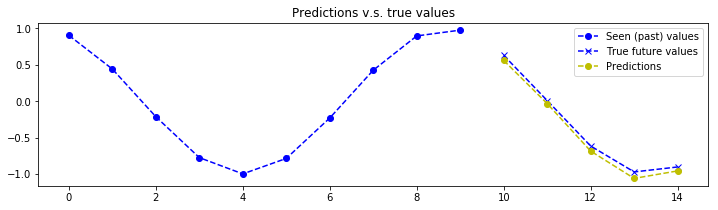

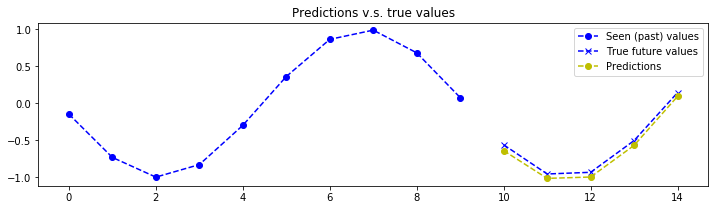

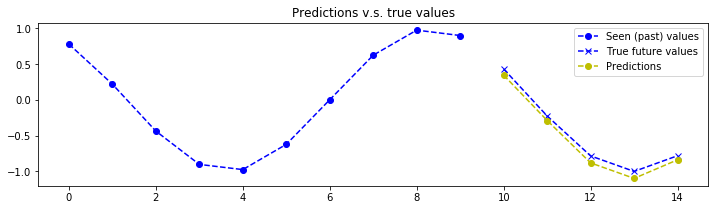

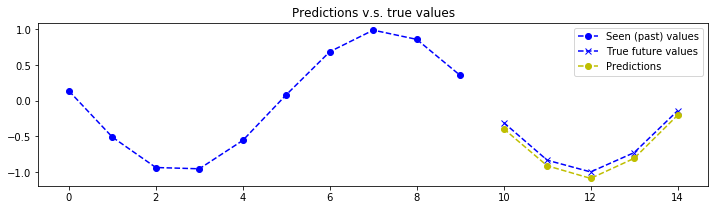

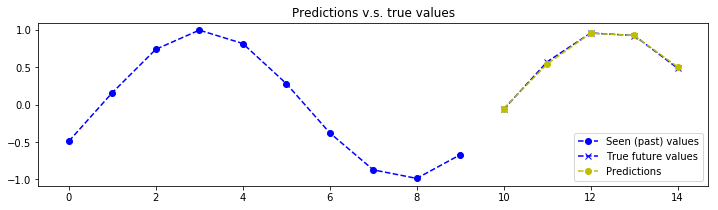

In [8]:
now = datetime.now(pytz.timezone('US/Eastern'))
seconds_since_epoch_end = time.mktime(now.timetuple())
now_microsecond_end = now.microsecond
if seconds_since_epoch_end != seconds_since_epoch_start:
    print('Communication and prediction took {} second(s).'.format(seconds_since_epoch_end - seconds_since_epoch_start))
else:
    duration_microseconds_part = now_microsecond_end - now_microsecond_start
    print('Communication and prediction took {} milliseconds.'.format(duration_microseconds_part/1000))

for j in range(nb_predictions): 
    plt.figure(figsize=(12, 3))

    for k in range(input_dim):
        past = X[:,j,k]
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)

    for k in range(output_dim):
        expected = Y[:,j,k]
        pred = outputs[:,j,k]

        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)

    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()